In [31]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

In [32]:
1000/0.511*0.500/4/np.pi

77.86445356746347

In [33]:
4*np.sqrt(2)

5.656854249492381

In [34]:
np.sqrt(2*22.5*10e-2*532e-9)/8/np.pi*1e6

61.56334563375514

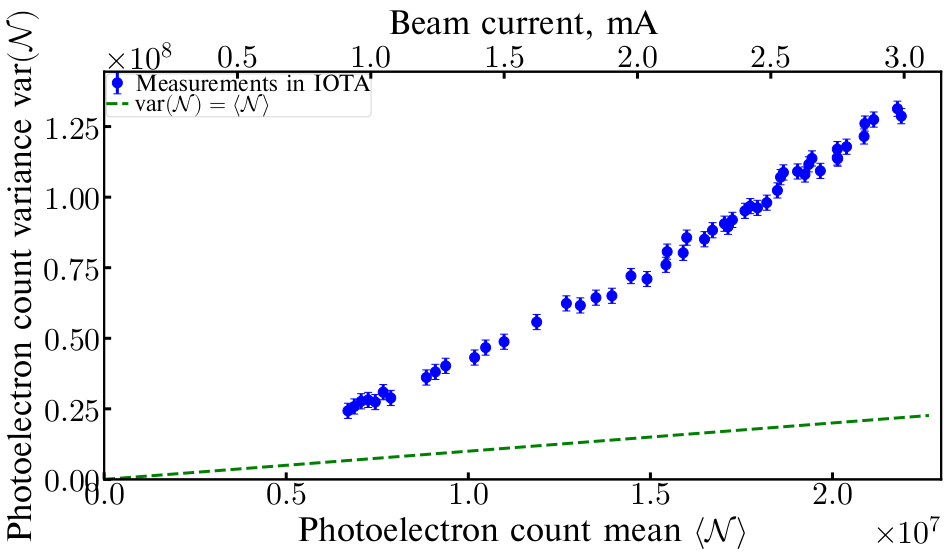

In [35]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [36]:
def f(x, alpha):
    return x+alpha*x**2
import scipy.optimize
alpha = scipy.optimize.curve_fit(f, meas_ROUND['N'], meas_ROUND['varN'])[0][0]
def NfromVarN(vn):
    return (-1+np.sqrt(1+4*alpha*vn))/2/alpha
NfromVarN(1.7e8)

24329020.288276903

In [37]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)

In [38]:
df.head()

,0.06,0.06857142857142857,0.07714285714285714,0.08571428571428573,0.09428571428571428,0.10285714285714287,0.11142857142857143,0.12
6.693879e+06,2.221984e+06,2.478707e+06,2.738453e+06,3.001321e+06,3.267457e+06,3.536921e+06,3.809616e+06,4.085455e+06
6.868607e+06,2.232259e+06,2.489990e+06,2.750771e+06,3.014674e+06,3.281838e+06,3.552339e+06,3.826136e+06,4.103022e+06
7.057312e+06,2.243369e+06,2.502187e+06,2.764074e+06,3.029091e+06,3.297380e+06,3.569039e+06,3.843973e+06,4.122039e+06
7.249983e+06,2.254729e+06,2.514671e+06,2.777677e+06,3.043832e+06,3.313292e+06,3.586113e+06,3.862211e+06,4.141467e+06
7.445827e+06,2.266292e+06,2.527336e+06,2.791512e+06,3.058828e+06,3.329460e+06,3.603451e+06,3.880718e+06,4.161206e+06


In [39]:
es = df.columns.values.astype(np.float64)

In [40]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [41]:
def reconstruct_e(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'B':df_EB, 'T':df_ET}[en]
    return np.interp(Mexp,df0.loc[avN,:],es)

In [42]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [43]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [44]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['e_rec_EB'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='B'), axis=1)
meas_ROUND['e_rec_ET'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='T'), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [45]:
# 1e3*meas_ROUND.loc[:,['e_rec_EB', 'e_rec_ET']].apply(lambda col:col-meas_ROUND.loc[:,'e_rec'],axis=0)

In [46]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [47]:
# calculation of reconstructed sy
import lattice.lattice as lattice
#from lattice.summary_in_undulator import CalcTransverseBeamParams
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [48]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [49]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [50]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [51]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [52]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")


bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_f_func = interp1d(bp_df["N"], bp_df['sz_um'],
                   bounds_error=False, fill_value="extrapolate")
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_f_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_f_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_f_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")

In [53]:
def remove_outliers_omce(df, c1, l1):
    di = df[c1].diff().abs()
    return df[di < l1]
    
def remove_outliers(df, c1, l1, niter):
    for _ in range(niter):
        df = remove_outliers_omce(df, c1, l1)
    return df
round_df = remove_outliers(round_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)
round_df = remove_outliers(round_df,'ex_um', 0.01, 10)
round_df = remove_outliers(round_df,'ey_um', 0.01, 10)

flat_df = remove_outliers(flat_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)


In [54]:
lt_f_df = pd.read_csv(shift.get_results_dir().fi("life_time_flat_03_16_2020.csv"),
            index_col=0)
lt_f_df

,I (mA),Beam life time (Sec),Life time error (Sec),N,ey_rec_no_transv_acc,ey_err_from_ex_bottom,ey_err_from_ex_top,ey_err_from_lt_top,ey_err_from_lt_bottom,ey_err_top,ey_err_bottom,ey_rec_gamma_plus
0,3.240886,676.157650,5,2.373104e+07,24.742437,2.869720,3.515617,0.367280,0.364574,3.534750,2.892785,25.531104
1,1.482210,634.747769,5,1.085332e+07,5.551383,0.682877,0.848093,0.087803,0.087114,0.852626,0.688411,5.727754
2,1.617933,616.999933,5,1.184714e+07,6.009796,0.727985,0.900767,0.097798,0.097009,0.906061,0.734420,6.200910
3,1.751888,608.728862,5,1.282801e+07,6.597309,0.789123,0.973504,0.108824,0.107933,0.979568,0.796470,6.807263
4,1.886356,597.752998,5,1.381264e+07,7.168050,0.849177,1.045236,0.120418,0.119415,1.052149,0.857532,7.396297
5,2.022060,590.130019,5,1.480631e+07,7.907104,0.931288,1.144767,0.134557,0.133422,1.152648,0.940797,8.158970
6,2.156100,578.761081,5,1.578781e+07,8.561822,1.005258,1.234812,0.148573,0.147295,1.243718,1.015992,8.834590
7,2.291651,573.125619,5,1.678036e+07,9.464040,1.111447,1.365355,0.165851,0.164410,1.375391,1.123541,9.765543
8,2.425155,573.631288,5,1.775794e+07,10.667419,1.255078,1.542470,0.186773,0.185153,1.553737,1.268661,11.007216
9,2.561412,557.909040,5,1.875566e+07,11.316006,1.334061,1.640349,0.203738,0.201920,1.652953,1.349256,11.676414


In [55]:
et_df = pd.read_csv("e_from_touschek_round.csv", index_col=0)

In [56]:

# prop = fm.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')

In [57]:
import matplotlib as mpl

In [58]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

/home/ilobach/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


Text(0, 0.5, 'Normal text ...')

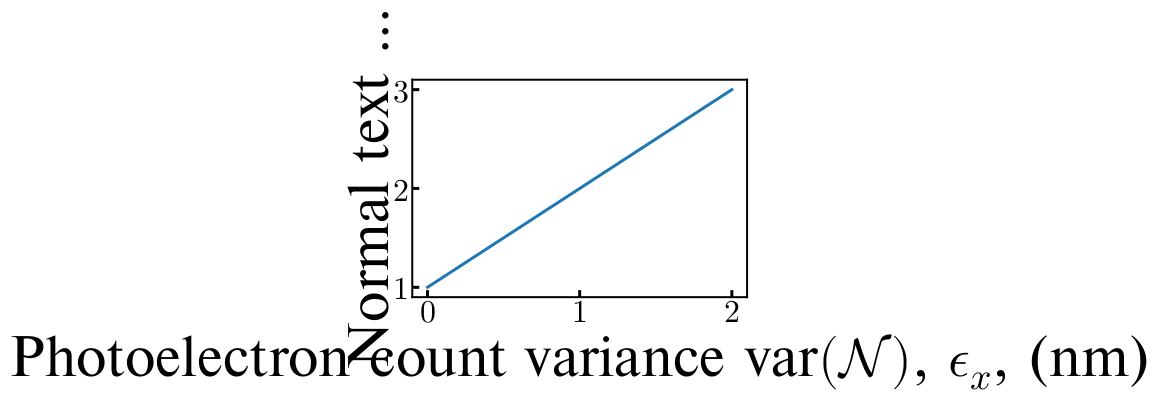

In [59]:
import matplotlib.font_manager as fm
fm._rebuild()
# -*- coding:utf-8 -*-
import matplotlib as mpl

mpl.use("pgf")

## TeX preamble
preamble = [
    r'\usepackage{amsmath}',
    r'\usepackage{unicode-math}',
    r'\usepackage{amsthm}',
    r'\setmainfont{Times}',
    r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}',
    r'\let\mathbb\relax',
    r'\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}',
    r'\usepackage{siunitx}'
]

params = {
#     'font.family': 'serif',
    'text.usetex': True,
#     'text.latex.unicode': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
}

mpl.rcParams.update(params)

import matplotlib.pyplot as plt

plt.plot([1, 2, 3])
plt.xlabel(r'Photoelectron count variance $\mathrm{var}(\mathcal{N})$, $\epsilon_x$, (\SI{}{nm})', fontsize=54)
plt.ylabel(r'Normal text ...', fontsize=54)

Remember that a small protion of SLM data at large Ibeam is extrapolated


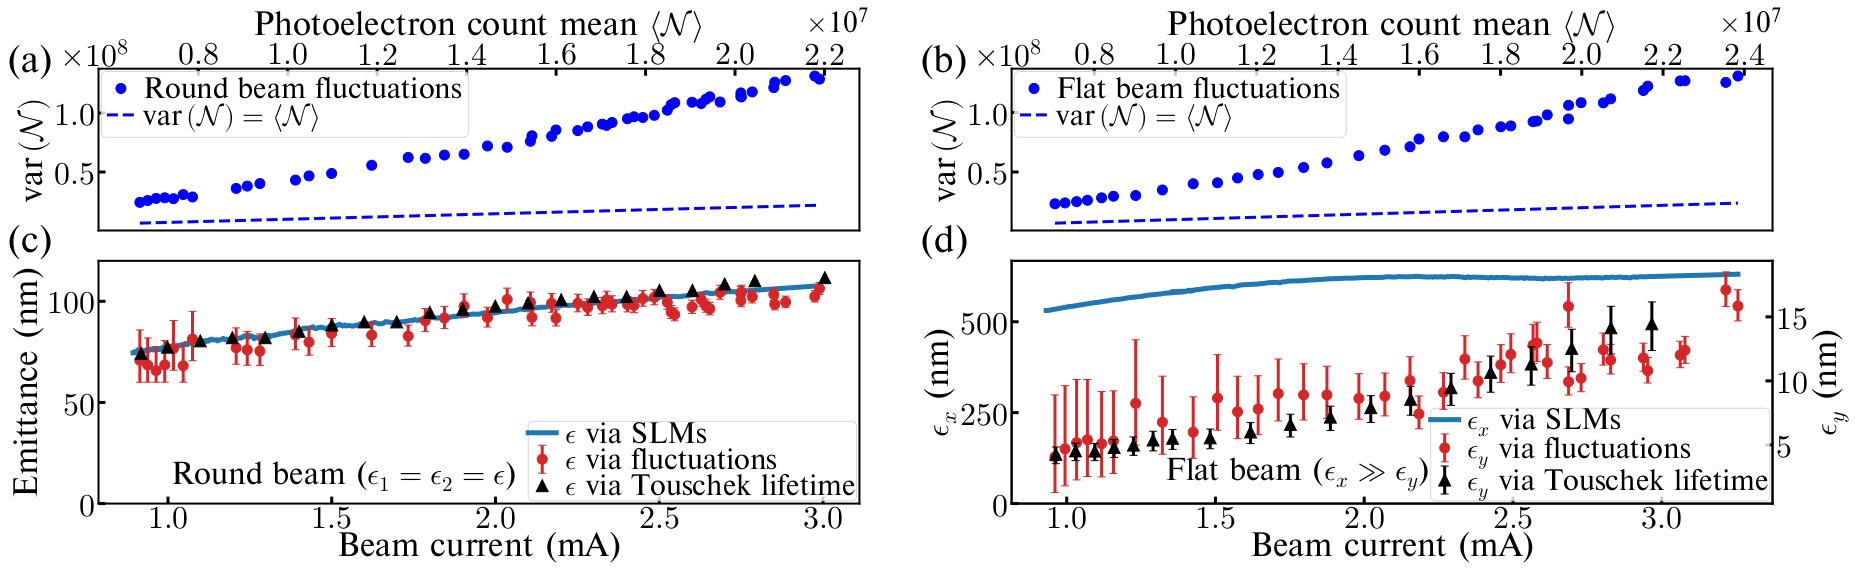

In [60]:
from fur.path_assistant import get_plot_style_sheet
import matplotlib as mpl
mpl.use("pgf")
plt.style.use(get_plot_style_sheet("prl"))
plt.rc('pgf', preamble=\
       r'\usepackage{amsmath}'
       +r'\usepackage{unicode-math}'
       +r'\usepackage{amsthm}'
       +r'\setmainfont{Times}'
       +r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'
       +r'\let\mathbb\relax'
       +r'\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}'
       +r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}'
      )
trianglesize=12
borderpad_fluct = 0.2
powerpos = 0.93, 1.38
subtitlepos = 0.55, 0.05
subfs = 28
avNlabel = r"Photoelectron count mean $\langle\mathcal{N}\rangle$"
beamCurLabel = r"Beam current (mA)"
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")
df = round_df

fs = 32
powerfs = 28


i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_ROUND['N'].max()/i_to_photoel],
                 'ex_um': ex_r_func(meas_ROUND['N'].max()),
                 'ey_um': ey_r_func(meas_ROUND['N'].max())
                 }),
    df], ignore_index=True)


fig, ax = plt.subplots(2,2, figsize=(30, 8), gridspec_kw={'height_ratios': [2, 3]})


photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
axRE = ax[1][0]
axRE.text(*subtitlepos, r"Round beam ($\epsilon_1=\epsilon_2=\epsilon$)", transform=axRE.transAxes,
       va='bottom', ha='right')
axRE.plot(photoel/i_to_photoel, 0.5*1000*(df['ex_um']+df['ey_um']),'-', linewidth=5 ,
        label=r'$\epsilon$ via SLMs')
axRE.plot(et_df['I (mA)'], 1000*et_df['e'], color='black',
                 marker='^', markersize=trianglesize, linestyle='None', label=r'$\epsilon$ via Touschek lifetime',
                zorder=102)

axRE.set_xlabel(beamCurLabel)
axRE.set_ylabel(r"Emittance (nm)")

color='tab:red'
yerr = 1e3*np.array([meas_ROUND['e_error_bottom'],meas_ROUND['e_error_top']])
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
axRE.errorbar(meas_ROUND['N']/i_to_photoel, 1e3*meas_ROUND['e_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, zorder=100,
             label=r"$\epsilon$ via fluctuations")
axRE.set_ylim(0, 1.05*axRE.get_ylim()[1])
handles, labels = axRE.get_legend_handles_labels()
order = [0,2,1]
# order = [0,1]
axRE.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='lower right')




axRF = ax[0][0]
pw=1e7
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_ROUND['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
axRF.plot(meas_ROUND['N']/pw, meas_ROUND['varN'],
            marker='o',linestyle='None',color='b',
            label = r'Round beam fluctuations')
axRF.plot(meas_ROUND['N']/pw, meas_ROUND['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
axRF.set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$")
axRF.set_xlabel(avNlabel)
handles, labels = axRF.get_legend_handles_labels()
order = [0,1]
axRF.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           loc='upper left', borderpad=borderpad_fluct)
axRF.set_xticks(ticks=np.arange(0.8,2.21,0.2))
axRF.set_xlim(np.asarray(axRE.get_xlim())*i_to_photoel/pw)
axRF.xaxis.tick_top()
axRF.xaxis.set_label_position('top') 
axRF.text(*powerpos, r"$\times\SI{e7}{}$", transform=axRF.transAxes,
      fontsize=powerfs, va='top', ha='left')
axRF.get_yaxis().get_offset_text().set_x(-0.05)
axRF.xaxis.labelpad = 0




axFE = ax[1][1]
axFE.set_ylabel(r"$\epsilon_x$ (nm)")

df = flat_df


# extrapolation:
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_FLAT['N'].max()/i_to_photoel],
                 'ex_um': ex_f_func(meas_FLAT['N'].max())}),
    df], ignore_index=True)
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ln1 = axFE.plot(photoel/i_to_photoel, 1000*df['ex_um'],
                    '-', linewidth=5, label=r'$\epsilon_x$ via SLMs', zorder=99)
axFE.set_ylim(0, 1.05*axFE.get_ylim()[1])
axFE.text(*subtitlepos, r"Flat beam ($\epsilon_x\gg\epsilon_y$)", transform=axFE.transAxes,
       va='bottom', ha='right')
axFE.set_xlabel(beamCurLabel)

axFEy = axFE.twinx()
color='tab:red'
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
ln2 = axFEy.errorbar(meas_FLAT['N']/i_to_photoel, 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, label=r'$\epsilon_y$ via fluctuations',
                    zorder=100)

yrange = axFEy.get_ylim()

ln3 = axFEy.errorbar(lt_f_df['I (mA)'], lt_f_df['ey_rec_no_transv_acc'], color='black',
                 marker='^', yerr=[lt_f_df['ey_err_top'], lt_f_df['ey_err_bottom']],
         markersize=trianglesize, linestyle='None', label=r'$\epsilon_y$ via Touschek lifetime',
                zorder=102)

axFEy.set_ylim(yrange)

axFEy.set_ylabel(r"$\epsilon_y$ (nm)")

lns = [ln1[0], ln2, ln3]
labs = [l.get_label() for l in lns]
axFEy.legend(lns, labs, loc='lower right')




axFF = ax[0][1]
pw=1e7
meas_FLAT = \
    pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'),
                index_col=0)
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_FLAT['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
axFF.plot(meas_FLAT['N']/pw,meas_FLAT['varN'],
            marker='o',linestyle='None',color='b',
            label = r'Flat beam fluctuations')
axFF.plot(meas_FLAT['N']/pw, meas_FLAT['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
axFF.set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$")
axFF.set_xlabel(avNlabel)
handles, labels = axFF.get_legend_handles_labels()
order = [0,1]
axFF.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            loc='upper left', borderpad=borderpad_fluct)
axFF.set_xticks(ticks=np.arange(0.8,2.41,0.2))
axFF.set_xlim(np.asarray(axFE.get_xlim())*i_to_photoel/pw)
axFF.xaxis.tick_top()
axFF.xaxis.set_label_position('top')
axFF.text(*powerpos, r"$\times\SI{e7}{}$", transform=axFF.transAxes,
      fontsize=powerfs, va='top', ha='left')
axFF.get_yaxis().get_offset_text().set_x(-0.05)
axFF.xaxis.labelpad = 0

axRE.xaxis.labelpad = -5
axFE.xaxis.labelpad = -5


fig.subplots_adjust(hspace=0.15)
for i, label in enumerate(('(a)', '(b)', '(c)', '(d)')):
    x = i // 2
    y = i - 2*x
    axx = ax[x][y] 
    axx.text(-0.12, 1.15, label, transform=axx.transAxes,
      fontsize=36, va='top', ha='left')
print("Remember that a small protion of SLM data at large Ibeam is extrapolated")
plt.savefig(path_assistant.get_PRL_images_dir().fi("iota_measurements.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [62]:
def get_M(n, varn):
    return n**2/(varn-n)

In [66]:
meas_ROUND.apply(lambda x: x['N']/get_M(x['N'], x['varN']), axis=1)

0     2.629013
1     2.761559
2     2.920880
3     2.883566
4     2.681341
5     3.032593
6     2.666278
7     3.080776
8     3.187241
9     3.289846
10    3.244459
11    3.457933
12    3.441526
13    3.693561
14    3.912815
15    3.713368
16    3.768085
17    3.665331
18    3.981104
19    3.763064
20    3.928917
21    4.218958
22    4.048441
23    4.354548
24    4.161727
25    4.283998
26    4.318681
27    4.224285
28    4.329300
29    4.407224
30    4.457066
31    4.362669
32    4.388399
33    4.538074
34    4.764867
35    4.830306
36    4.729951
37    4.613645
38    4.768913
39    4.850585
40    4.558024
41    4.664958
42    4.812237
43    4.641878
44    4.782109
45    4.822496
46    5.035884
47    5.032817
48    5.027928
49    4.879419
dtype: float64

In [67]:
meas_FLAT.apply(lambda x: x['N']/get_M(x['N'], x['varN']), axis=1)

0     2.308674
1     2.300910
2     2.314048
3     2.351639
4     2.457890
5     2.497533
6     2.351645
7     2.605396
8     2.841774
9     2.708119
10    2.899956
11    2.978339
12    2.961578
13    3.088381
14    3.198017
15    3.389292
16    3.504551
17    3.513407
18    3.857503
19    3.794331
20    3.644538
21    3.891143
22    3.883204
23    3.857346
24    3.905601
25    3.910032
26    4.115621
27    3.805516
28    4.387844
29    4.413467
30    4.261172
31    4.379661
32    4.504749
33    4.644682
34    4.638818
35    4.616935
36    4.318441
37    4.475496
dtype: float64

In [27]:
from fur.path_assistant import get_plot_style_sheet
import matplotlib as mpl
mpl.use("pgf")
plt.style.use(get_plot_style_sheet("prab"))
plt.rc('pgf', preamble=r'\usepackage{amsmath}\usepackage{unicode-math}\usepackage{amsthm}\setmainfont{Times}\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}\let\mathbb\relax\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}'
       r'\usepackage{siunitx}')

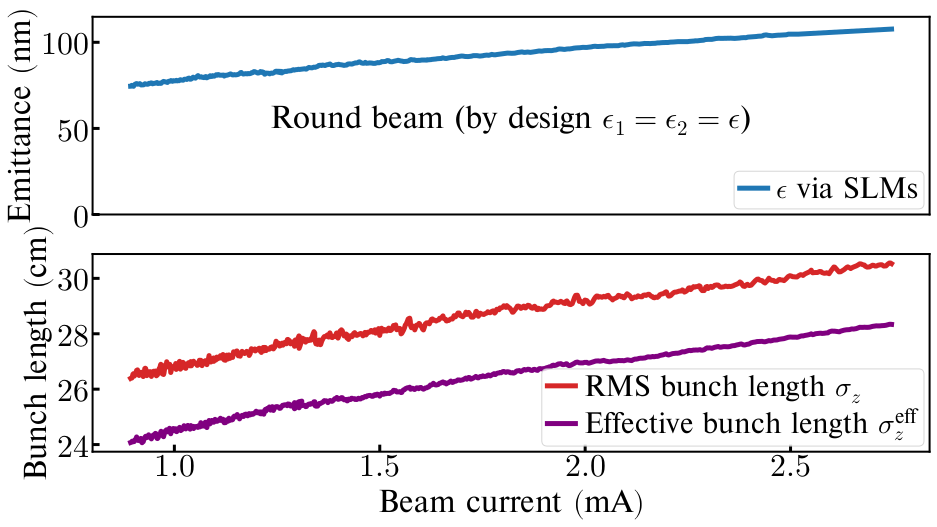

In [35]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axRE, ax2 = axs
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = round_df
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute': [-meas_ROUND['N'].max()/i_to_photoel],
                  'ex_um': ex_r_func(meas_ROUND['N'].max()),
                  'ey_um': ey_r_func(meas_ROUND['N'].max())
                  }),
    df], ignore_index=True)
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
axRE.text(0.5, 0.4, r"Round beam (by design $\epsilon_1=\epsilon_2=\epsilon$)", transform=axRE.transAxes, va='bottom', ha='center')
axRE.plot(photoel/i_to_photoel, 0.5*1000*(df['ex_um']+df['ey_um']), '-', linewidth=5,
          label=r'$\epsilon$ via SLMs')
# axRE.plot(photoel/i_to_photoel, 1000*df['ey_um'],'-', linewidth=5 ,
#         label=r'$\epsilon_y$ via SLMs')


axRE.set_ylabel(r"Emittance $(\SI{}{nm})$")

axRE.set_ylim(0, 1.05*axRE.get_ylim()[1])
axRE.legend(loc='lower right')
axRE.get_xaxis().set_visible(False)

ax2.plot(photoel/i_to_photoel, df['N:IWCMBR'], '-', linewidth=5,
         label=r'RMS bunch length $\sigma_z$', color='tab:red')
ax2.plot(photoel/i_to_photoel, df['N:IWCMBE'], '-', linewidth=5,
         label=r'Effective bunch length $\sigma_z^{\mathrm{eff}}$',
         color='purple')
ax2.legend(loc='lower right')
ax2.set_ylabel("Bunch length $(\SI{}{cm})$")
ax2.set_yticks(ticks=np.arange(24, 31, 2))


ax2.set_xlabel(r"Beam current $(\SI{}{mA})$")
# ax2.set_ylim(0, 1.05*ax2.get_ylim()[1])
fig.subplots_adjust(hspace=0.2)
plt.savefig(path_assistant.get_PRL_images_dir().fi("ex_ey_round_beam.png"),
            dpi=300, bbox_inches='tight')
plt.show()